# **1. Importación de *modules***

In [ ]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV, ElasticNet
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn import preprocessing
scale = preprocessing.scale()

import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.stats.outliers_influence import variance_inflation_factor

from scipy import stats

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# **2. Importación del dataset *properatti_tp2.csv***

In [ ]:
data = pd.read_csv("../data/properatti_tp2.csv", sep = ",", low_memory=False) 
data.head(3)
data.shape

# **3. Tratamiento de los datos**

In [ ]:
# Definimos parámetros globales para matplotlib.
plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['font.size'] = 16
sns.heatmap(data.iloc[:, :4].corr(), vmin = -1, vmax = 1, center = 0, cmap = "YlGnBu", annot = True)

# **4.Modelos**

## Creo una función que ingreso features y devuelve el MAE  train_test_mae

In [ ]:
# Definimos una función que acepta una lista de features, hace el split entre train y test,
# reservando un 25% de las observaciones para testeo, y devuelve la prueba MAE.

def train_test_mae(feature_cols):
    X = data[feature_cols]
    y = data.precio_por_m2
    # Como estamos trabajando con observaciones ordenadas en el tiempo, ponemos
    # shuffle=False para evitar data leakage
    X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False)
    linreg = LinearRegression()
    linreg.fit(X_train, y_train)
    y_pred = linreg.predict(X_test)
    return mean_absolute_error(y_test, y_pred)


In [ ]:
train_test_mae(['sup_total','sup_cubierta','habitaciones'])

In [ ]:
train_test_mae(['sup_total'])

In [ ]:
train_test_mae(['sup_cubierta'])

In [ ]:
train_test_mae(['habitaciones'])

## **4.1 Regresión lineal simple (RLS)**

#### 4.1.1 funcion rls_func

In [ ]:
def rls_func(X,y,columna):
    # Como estamos trabajando con observaciones ordenadas en el tiempo, ponemos
    # shuffle=False para evitar data leakage    shuffle=False
    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state = 1, shuffle = False)
    lm = LinearRegression() # Fiteamos el modelo sobre los vectores X e y.
    model = lm.fit(Xtrain, ytrain)
    print(f'''    Coef\t{model.coef_}''')
    print(f'''    intercept\t{model.intercept_}''')
    test_sklearn = np.array(Xtest).reshape(-1,1)
    ypred = model.predict(test_sklearn)
    
    print(f'''    MAE\t{mean_absolute_error(ytest, ypred).round(2)}
    MSE\t{mean_squared_error(ytest, ypred).round(2)}
    RMSE\t{np.sqrt(mean_squared_error(ytest, ypred)).round(2)}
    R2\t{r2_score(ytest, ypred).round(2)}
    ''')

    sns.regplot(data = data, x = columna, y = 'precio_por_m2', ci = 95, scatter_kws = {"color": "blue", 's': 10}, line_kws = {"color": "red"})
    #return mean_absolute_error(y_test, y_pred)


### Regresión lineal simple (RLS) de a una feature a la vez **sin normalización**

#### 4.1.2 scater plot

In [ ]:
#sup_total
xs = data[["sup_total"]]
ys = data["precio_por_m2"]

plt.scatter(xs, ys, color='r')
plt.xlabel("SurfTot ")
plt.ylabel("PUPM ")
plt.show()

#### 4.1.3 Superficie total

In [ ]:
# Superficie total
print("*** Superficie total ***")
X = data[['sup_total']]
y = data['precio_por_m2']
rls_func(X,y,'sup_total')


#### 4.1.4 Superficie cubierta

In [ ]:
# Superficie cubierta
print("*** Superficie cubierta ***")
X = data[['sup_cubierta']]
y = data['precio_por_m2']
rls_func(X,y,'sup_cubierta')


#### 4.1.5 Habitaciones

In [ ]:
# Habitaciones
print("*** habitaciones ***")
X = data[['habitaciones']]
y = data['precio_por_m2']
rls_func(X,y,'habitaciones')

### RLS a una feature a la vez **normalizando** (usando Scale)

#### 4.1.6 scater plot

In [ ]:
#Normalizo con sup_total
xs = scale(data[["sup_total"]])
ys = scale(data["precio_por_m2"])

plt.scatter(xs, ys, color='r')
plt.xlabel("SurfTot standardized")
plt.ylabel("PUPM standardized")
plt.show()

#### 4.1.7 Superficie total

In [ ]:
# Normalizo con sup_total
print("*** Superficie total con  Normalizacion  ***")
X = scale(data[["sup_total"]])
y = scale(data["precio_por_m2"])
rls_func(X,y,'sup_total')

Comparando los resultados de la regresion lineal simple usando sup_total con y sin normalizacion se tiene:
Sin normalización: 
- MAE	700.94
- MSE	944445.18
- RMSE	971.83
- R2	0.16

Con Normalización
- MAE	0.65
- MSE	0.82
- RMSE	0.91
- R2	0.16

#### 4.1.8 Superficie cubierta

In [ ]:
# Normalizo con ssup_cubierta
print("*** Superficie totalcon  Normalizacion  ***")
X = scale(data[["sup_cubierta"]])
y = scale(data["precio_por_m2"])
rls_func(X,y,'sup_cubierta')

#### 4.1.9 Habitaciones

In [ ]:
# Normalizo con habitaciones
print("*** habitaciones  ***")
X = scale(data[["habitaciones"]])
y = scale(data["precio_por_m2"])
rls_func(X,y,'habitaciones')

## **4.3 Regresión lineal múltiple (RLM)**

### 4.3.1 funcion que tome features y aplique RLM (rlm_func y rlm_func_orig)

In [ ]:
# Definimos una función que acepta una lista de features, hace el split entre train y test,
# reservando un 25% de las observaciones para testeo, y devuelve la prueba MAE.

def rlm_func(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False)
    linreg = LinearRegression()
    linreg.fit(X_train, y_train)
    y_pred = linreg.predict(X_test)
        
    n = len(y_train)
    p = X_train.shape[1]
    R2 = r2_score(y_test, y_pred)
    R2_ajustado = 1 - (1 - R2)*((n-1)/(n - p - 1))
    
    print(f'''    
    Intercepto\t{linreg.intercept_.round(4)}
    MAE\t\t{mean_absolute_error(y_test, y_pred).round(4)}
    MSE\t\t{mean_squared_error(y_test, y_pred).round(4)}
    RMSE\t{np.sqrt(mean_squared_error(y_test, y_pred)).round(4)}
    R2\t\t{(R2).round(4)}
    R2ADJ\t{(R2_ajustado).round(4)}
    ''')

    plt.plot(y,y, '-.',c='grey')
    plt.scatter(y_pred, y_test, s=30, c='r', marker='+', zorder=10)
    plt.xlabel("Predicciones usando todas las variables")
    plt.ylabel("Valores reales ")
    plt.title('Prediccion de precio por m$^2$ utilizando RLM')
    plt.show()

### 4.3.2 RLM con las 3 features originales juntas **sin normalización**

In [ ]:
feature_cols = ['sup_total','sup_cubierta','habitaciones']
X = data[feature_cols]
y = data.precio_por_m2
rlm_func(X, y)

### 4.3.3 RLM con las 3 features originales juntas **Con normalización**  (usando Scale)

In [ ]:
feature_cols =['sup_total','sup_cubierta','habitaciones']
xs_orig = scale(data[feature_cols])
ys_orig = scale(data["precio_por_m2"])

rlm_func(xs_orig,ys_orig)

###  4.3.4 RLM con TODOS los features (excluyendo place_name) **sin normalizar**

    
    Intercepto	1572.6768
    MAE		6771378.9124
    MSE		9.059311665737739e+16
    RMSE	300986904.4616
    R2		-86717443234.47
    R2ADJ	-88027213063.9106
    


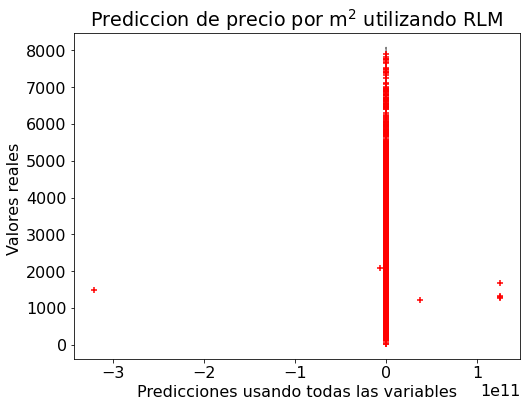

In [347]:
cols2drop = list(data.filter(regex = '^pn_', axis = 1).columns) + ['precio_por_m2']
X_am = data.drop(columns = cols2drop)
y_am = data['precio_por_m2']
rlm_func(X_am, y_am)

### 4.3.5 RLM con TODOS los features (excluyendo place_name) **con normalizacion**  (usando Scale)

    
    Intercepto	8759221073.263
    MAE		73509083603.8616
    MSE		6.038891830165123e+24
    RMSE	2457415681191.345
    R2		-6.665094800401379e+24
    R2ADJ	-6.76576359037276e+24
    


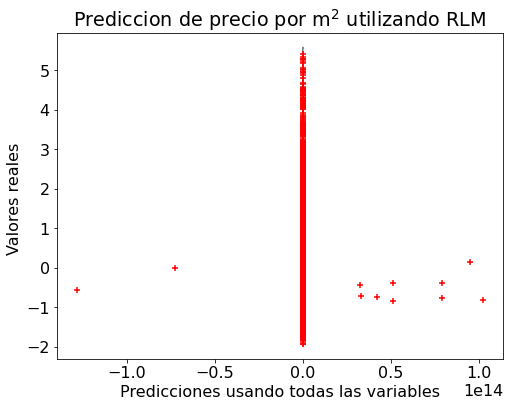

In [348]:
cols2drop = list(data.filter(regex = '^pn_', axis = 1).columns) + ['precio_por_m2']
Xs_am = scale(data.drop(columns = cols2drop))
ys_am = scale(data['precio_por_m2'])
rlm_func(Xs_am, ys_am)

##  **<font color='red'>4.4 Siguientes pasos regularización </font>**

### Ridge Regression

In [ ]:
X = data[['sup_total','sup_cubierta','habitaciones']]
y = data[['precio_por_m2']]

X_train, X_test, y_train, y_test = train_test_split(X, y)

# Instanciamos el modelo.
lm = LinearRegression()
# Fiteamos el modelo sobre los vectores xs_orig e ys_orig.
model = lm.fit(X_train, y_train)
# Guardamos  las predicciones en un nuevo vector que llamaremos predictions.
ypred = lm.predict(X_test)

#Modelo Ridge
ridge = Ridge(alpha=0.5, normalize=True)
ridge.fit(X_train,y_train)
ypred_ridge = ridge.predict(X_test)

print ('R2:', r2_score(y_test, ypred))
print ("R2_Ridge:", r2_score(y_test, ypred_ridge))

In [ ]:
# Veamos los coeficientes de la regresión Ridge:    
ridge.coef_

### Regression Lasso

In [ ]:
X = data[['sup_total','sup_cubierta','habitaciones']]
y = data[['precio_por_m2']]

X_train, X_test, y_train, y_test = train_test_split(X, y)

# Instanciamos el modelo lineal
lm = LinearRegression()
# Fiteamos el modelo sobre los vectores xs_orig e ys_orig.
model = lm.fit(X_train, y_train)
# Guardamos  las predicciones en un nuevo vector que llamaremos predictions.
ypred = lm.predict(X_test)

#Modelo Lasso
lasso = Lasso(alpha=0.5, normalize=True)
lasso.fit(X_train,y_train)
ypred_lasso = lasso.predict(X_test)

print ('R2:', r2_score(y_test, ypred))
print ("R2_Lasso:", r2_score(y_test, ypred_lasso))

In [ ]:
# Veamos los coeficientes de la regresión Lasso:    
lasso.coef_

### Elastic Net

In [ ]:
X = data[['sup_total','sup_cubierta','habitaciones']]
y = data[['precio_por_m2']]

X_train, X_test, y_train, y_test = train_test_split(X, y)

# Instanciamos el modelo lineal
lm = LinearRegression()
# Fiteamos el modelo sobre los vectores xs_orig e ys_orig.
model = lm.fit(X_train, y_train)
# Guardamos  las predicciones en un nuevo vector que llamaremos predictions.
y_pred = lm.predict(X_test)

#Modelo elastic Net
elastic_net = ElasticNet(alpha=0.5, normalize=True)
elastic_net.fit(X_train, y_train)
ypred_elastic = elastic_net.predict(X_test)

plt.title("Muestra de datos #1")
plt.scatter(y_pred, y_test, c='r')

print ('R2:', r2_score(y_test, ypred))
print ("R2_Elastic:", r2_score(y_test, ypred_elastic))

In [ ]:
# Veamos los coeficientes de la regresión ElasticNet:
elastic_net.coef_

## CV optimización Lambda

In [ ]:
# instanciamos un modelo 
rlmcv = RidgeCV(alphas=np.linspace(0.1,100, 1000), cv=3, normalize=True,scoring='r2')


# Ajustamos nuevamente nuestro modelo, esta vez con RidgeCV
X = np.vander(xs, 4)[:,:-1]
y = ys
rlmcv.fit(X, y)
predictions = rlmcv.predict(X)

plt.scatter(xs, ys)
plt.title("Muestra de datos #1")
plt.scatter(xs, predictions, c='r')
plt.show()
print ("r^2:", rlmcv.score(X, ys))
print ("alpha:", rlmcv.alpha_)

X = np.vander(xs2, 4)[:,:-1]
predictions = rlmcv.predict(X)

plt.scatter(xs2, ys2)
plt.title("Muestra de datos #2")
plt.scatter(xs2, predictions, c='r')
plt.show()
print ("r^2:", rlmcv.score(X, ys2))

In [ ]:
lassocv = LassoCV(alphas=np.linspace(0.01,100, 1000), cv=3, normalize=True)
xs, ys = generate_data()


# Ajustamos nuevamente nuestro modelo, esta vez con LassoCV
X = np.vander(xs, 4)[:,:-1]
y = ys
lassocv.fit(X, y)
predictions = lassocv.predict(X)

plt.scatter(xs, ys)
plt.title("Muestra de datos #1")
plt.scatter(xs, predictions, c='r')
plt.show()
print ("r^2:", lassocv.score(X, ys))
print ("alpha:", lassocv.alpha_)

X = np.vander(xs2, 4)[:,:-1]
predictions = lassocv.predict(X)

plt.scatter(xs2, ys2)
plt.title("Muestra de datos #2")
plt.scatter(xs2, predictions, c='r')
plt.show()
print ("r^2:", lassocv.score(X, ys2))

In [ ]:
# Definimos el rango de de búsqueda del hiperparametro explicitamente
lm_lasso = LassoCV(alphas=[0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01,\
                                        0.05, 0.1, 1, 5, 10],\
                                        normalize = False, cv = 5) 

model_cv = lm_lasso.fit(X_train, y_train)

model_cv.score(X_train, y_train)

model_cv.coef_
model_cv.intercept_
model_cv.alpha_
model_cv.score(X_train, y_train)

In [ ]:
best_alpha = model_cv.alpha_

#L1_wt : 0, the fit is ridge regression. 1, the fit is the lasso 

no_reg_model = sm.OLS(y_train, X_train_sm)

reg_model = no_reg_model.fit_regularized(alpha = best_alpha, L1_wt = 1)

reg_model.params
sns.scatterplot(x=reg_model.params, y=no_reg_model_params);

reg_residuals = y_train - reg_model.fittedvalues

linear_residuals = y_train - model.fittedvalues

sns.scatterplot(x = reg_residuals, y = linear_residuals)

In [ ]:
sm_prediction = reg_model.predict(X_test_sm)
sm_prediction

In [ ]:
skl_lasso = Lasso(alpha = best_alpha, fit_intercept=True, normalize=False)

skl_lasso = skl_lasso.fit(X= X_train, y = y_train)

skl_prediction = skl_lasso.predict(X_test)

In [ ]:
skl_residuals = y_test - skl_prediction

sm_residuals = y_test - sm_prediction

sns.scatterplot(x = skl_residuals, y = sm_residuals)

In [ ]:

lasso_coef = np.insert(skl_lasso.coef_, 0, skl_lasso.intercept_)

sns.scatterplot(x = lasso_coef, y = reg_model.params);


In [ ]:
sm.tools.eval_measures.rmse(y_test, sm_prediction)
sm.tools.eval_measures.meanabs(y_test, sm_prediction)
r2_score(y_test, sm_prediction)
np.sqrt(mean_squared_error(y_test, skl_prediction))
mean_absolute_error(y_test, skl_prediction)
r2_score(y_test, skl_prediction)